#### Google Colab Implementation

In [1]:
#Keras library for CIFAR-10 dataset
from keras.datasets import cifar10

#Downloading the CIFAR dataset
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

### Importign Remaining Library

In [2]:
#importing other required libraries
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications import VGG19 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical

### Here, we will split the downloaded dataset into training, test and validation sets.

In [3]:
#defining training and test sets
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3)

In [4]:
#Dimension of the dataset
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))


((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


#### We need to do one hot encoding here because we have 10 classes and we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10

In [5]:
#One Hot Encoding
y_train=to_categorical(y_train)
y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

In [6]:
#Verifying the dimension after one hot encoding
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))


((35000, 32, 32, 3), (35000, 10))
((15000, 32, 32, 3), (15000, 10))
((10000, 32, 32, 3), (10000, 10))


### Data Augmentation

In [7]:
#Image Data Augmentation
train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)

val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1)

test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True, zoom_range=.1)

#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

In [8]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='accuracy', factor=.01, patience=3, min_lr=1e-5)

### Defining VGG19 as a Deep Convolutional Neural Network

In [9]:
#Defining the VGG Convolutional Neural Net
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (32,32,3), classes = y_train.shape[1])

#### Now, we will define VGG19 as a deep learning architecture. For this purpose, it will be defined as a Keras Sequential model with several dense layers. 

In [10]:
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

In [11]:
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [12]:
#Adding the Dense layers along with activation and batch normalization
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.3))
model.add(Dense(10,activation=('softmax'))) 

#Checking the final model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1

#### As we have defined our model, now we need to initialize the hyperparameters that are required to train the model and then finally, we will compile our model.

In [13]:
# Initializing the hyperparameters
batch_size= 100
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

### Training the model

In [14]:
#Training the model it may take around 25 to 30 minute on GPU 
model.fit(train_generator.flow(x_train, y_train, batch_size= batch_size),
                    epochs = epochs, steps_per_epoch = x_train.shape[0]//batch_size, 
                    validation_data = val_generator.flow(x_val, y_val, batch_size = batch_size),
                    validation_steps = 100, callbacks=[lrr], verbose = 1)


Epoch 1/50
350/350 [==============================] - 26s 73ms/step - loss: 1.7504 - accuracy: 0.3487 - val_loss: 1.3199 - val_accuracy: 0.5261
Epoch 2/50
350/350 [==============================] - 25s 73ms/step - loss: 1.0134 - accuracy: 0.6461 - val_loss: 0.8328 - val_accuracy: 0.7106
Epoch 3/50
350/350 [==============================] - 25s 73ms/step - loss: 0.7674 - accuracy: 0.7371 - val_loss: 0.6932 - val_accuracy: 0.7655
Epoch 4/50
350/350 [==============================] - 26s 73ms/step - loss: 0.6422 - accuracy: 0.7808 - val_loss: 0.6885 - val_accuracy: 0.7723
Epoch 5/50
350/350 [==============================] - 25s 73ms/step - loss: 0.5638 - accuracy: 0.8072 - val_loss: 0.6421 - val_accuracy: 0.7877
Epoch 6/50
350/350 [==============================] - 25s 72ms/step - loss: 0.4989 - accuracy: 0.8294 - val_loss: 0.5939 - val_accuracy: 0.8024
Epoch 7/50
350/350 [==============================] - 25s 72ms/step - loss: 0.4560 - accuracy: 0.8437 - val_loss: 0.5770 - val_accuracy:

#### Plotting the traingin and validataion loss and accuracy

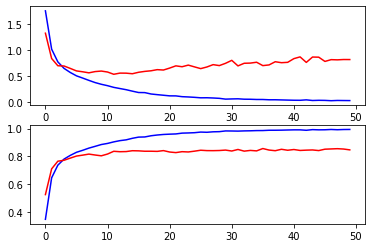

In [15]:
#Plotting the training and validation loss and accuracy
f,ax=plt.subplots(2,1) 

#Loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

### Predictions

In [17]:
#Making prediction
y_pred=np.argmax(model.predict(x_test),axis=-1)
y_true=np.argmax(y_test,axis=1)

In [18]:
y_pred

array([5, 8, 8, ..., 5, 1, 7])

In [19]:
y_true

array([3, 8, 8, ..., 5, 1, 7])

###  Confusion Matrix

In [21]:
conf_mx=confusion_matrix(y_true, y_pred)
conf_mx

array([[878,  13,  22,  16,  16,   0,  14,  10,  17,  14],
       [  8, 945,   0,   3,   0,   5,   1,   0,   4,  34],
       [ 25,   1, 819,  27,  25,  33,  48,  15,   2,   5],
       [  8,   4,  31, 609,  44, 191,  71,  22,   4,  16],
       [  5,   4,  41,  30, 834,  19,  36,  26,   0,   5],
       [  3,   3,  19,  82,  27, 818,  18,  25,   1,   4],
       [  5,   5,  22,  27,  10,   9, 914,   1,   1,   6],
       [  9,   5,  10,  19,  40,  28,   3, 876,   0,  10],
       [ 38,  30,   4,   6,   4,   2,   2,   0, 882,  32],
       [ 12,  68,   4,   4,   0,   2,   1,   0,   3, 906]])

In [36]:
## Normalization of confustion Matrix
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

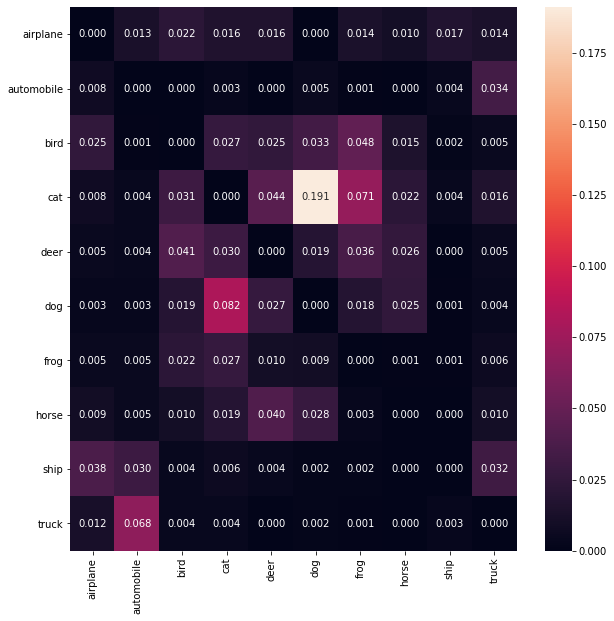

In [37]:
import seaborn as sns
plt.figure(figsize=(10,10))
#Defining the class labels
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
x_label, y_label=class_names,class_names
sns.heatmap(norm_conf_mx, annot=True, fmt=".3f",xticklabels=x_label, yticklabels=y_label)
plt.show()